In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil


CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pins-face-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F543939%2F992580%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T045942Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D843b3dac282017a3afb6287d58fbac13e43ecceafd7390207e1d46d2ac58c34023e33c6b3e93d95c48a2b6bca25c89151de2eabe9c9525a041d0015ec4fbb6bfd74e2bad216f8641f3b03751678da52fc7feb219d3530335c08d78b6aa0e2c50502d51751efd4e68a653b7da293b5227b73590006327cdc64b4364705ec44ac7ae374d338e44df638c3a5465ac901864fe3c572f958c8735015e09d629cfcac5509a7f2059d3f8ec92ded245316c2b950df981238e551dbf7708e94b17750b6b32ac2aa8d18f0ba39061dc66de8295f89dc39ca0d6fc51834fa8840e69d77b4b8a7f024fbbca7dcd7c0ef4525463936506a21b698be90c0cd1cc9c9e5dbfe01e,vgg-face-weights:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1267072%2F2111872%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T045942Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da52a95d0c1df45f07cedab6f399bec63d6559eee2c40fe2be1041da804d2e68da341eca2be34519211a852e46ded9f2be2514fe7dc671d35b573944af282ef17d78b45fb0720d8ef97654389cfc3e27c2b720b7e2f88aeee40857e22531b462f03898762e3990c556ea991596f63ab4a3088b34ba3b0a52a10d88862b8a0404e17a7deaab4603439d93832f99d48ca61ff2163ef9fd2071b0c4981a690d20fda0c241a1fd5801dafd7707708bd914a4879e10f57280d335b9e6a6a6df10479f0dc19993111cc0cb0d87c8c3b76f6ff64265eed217459322e27b90ca6d74b4984e1679931702754454c1a77a1bbe9c0fdf107380df90873e996df7d361b89d9da'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 389784397 bytes downloaded
Downloaded and uncompressed: pins-face-recognition
[==================================================] 545997436 bytes downloaded
Downloaded and uncompressed: vgg-face-weights
Data source import complete.


In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Start webcam

In [ ]:
image_file = take_photo()

<IPython.core.display.Javascript object>

NameError: name 'eval_js' is not defined

Click 'Capture' to make photo using your webcam.

<br>
<h2 style = "font-size:40px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> Celebrity Face Recognition using VGGFace Model </h2>
<br>

[![Celebrity.png](https://i.postimg.cc/5yp4715n/Celebrity.png)](https://postimg.cc/xNJV8w4z)

<a id = '0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #007580; color : #fed049; border-radius: 5px 5px; text-align:center; font-weight: bold" >Table of Contents</h2>

1. [Overview](#1.0)
2. [Import the necessary libraries](#2.0)
3. [Data Collection](#3.0)
4. [Feature Engineering](#4.0)
	- [VGG Face model](#4.1)
	- [Generate embeddings for each image in the dataset](#4.2)
	- [Plot images and get distance between the pairs](#4.3)
	- [Create train and test sets](#4.4)
	- [Reduce dimensions using PCA](#4.5)
5. [Model Building and Validation](#5.0)
    - [Build a Machine Learning Classifier](#5.1)
    - [Validate Celebrity Images](#5.2)
6. [Conclusion](#6.0)

<a id = '1.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 1. Overview </h2>

### Project Description:

In this hands-on project, the goal is to build a face identification model to recognize faces.

### Data Description:

**Aligned Face Dataset from Pinterest**

This dataset contains 17534 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.

### Objective:

In this problem, we use a pre-trained model trained on Face recognition to recognize similar faces. Here, we are particularly interested in recognizing whether two given faces are of the same person or not.

<a id = '2.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 2. Import the necessary libraries </h2>

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# used to supress display of warnings
import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score

#### Setting Options

In [ ]:
# suppress display of warnings
warnings.filterwarnings('ignore')

<a id = '3.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 3. Data Collection </h2>

In [ ]:
import os
source_dir=os.path.join('/kaggle','input','pins-face-recognition','105_classes_pins_dataset')

<p style = "font-size:20px; color: #007580 "><strong> Function to load images </strong></p>
- Define a function to load the images from the extracted folder and map each image with person id


In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata(source_dir)

In [ ]:
print('metadata shape :', metadata.shape)

metadata shape : (17534,)


In [ ]:
metadata[1500]

/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Brian J. Smith/Brian J. Smith243_676.jpg

In [ ]:
type(metadata[1500]), metadata[1500].image_path()

(__main__.IdentityMetadata,
 '/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Brian J. Smith/Brian J. Smith243_676.jpg')

<p style = "font-size:20px; color: #007580 "><strong> Define a function to load an image </strong></p>
- Define a function to load image from the metadata

In [ ]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

<p style = "font-size:20px; color: #007580 "><strong> Load a sample image</strong></p>
- Load one image using the function "load_image"

array([[[33, 36, 51],
        [34, 37, 52],
        [39, 43, 55],
        ...,
        [47, 40, 47],
        [57, 50, 57],
        [67, 60, 67]],

       [[39, 42, 57],
        [42, 45, 60],
        [47, 51, 63],
        ...,
        [59, 52, 59],
        [73, 66, 73],
        [85, 78, 85]],

       [[51, 55, 67],
        [53, 57, 69],
        [58, 62, 74],
        ...,
        [76, 69, 76],
        [86, 79, 86],
        [94, 87, 94]],

       ...,

       [[93, 42, 38],
        [93, 42, 38],
        [96, 45, 41],
        ...,
        [61, 35, 36],
        [60, 34, 35],
        [59, 33, 34]],

       [[94, 44, 37],
        [89, 39, 32],
        [89, 39, 32],
        ...,
        [60, 34, 35],
        [59, 33, 36],
        [58, 32, 35]],

       [[99, 49, 42],
        [89, 39, 32],
        [85, 35, 28],
        ...,
        [60, 34, 37],
        [59, 33, 36],
        [58, 32, 35]]], dtype=uint8)
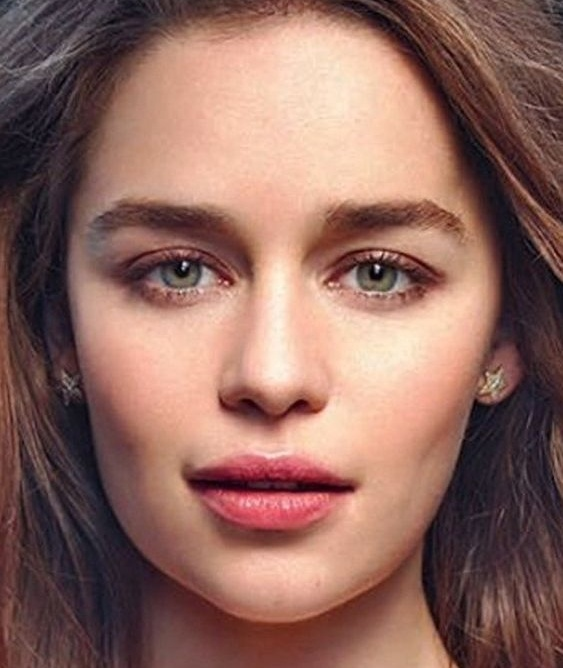

In [ ]:
load_image('/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Emilia Clarke/Emilia Clarke247_998.jpg')

<a id = '4.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 4. Feature Engineering </h2>

<a id = '4.1'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.1 VGG Face model </strong></p>
- Here we are giving you the predefined model for VGG face

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

<p style = "font-size:20px; color: #007580 "><strong> Load the model </strong></p>

- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [ ]:
model = vgg_face()

model.load_weights('../input/vgg-face-weights/vgg_face_weights.h5')

<p style = "font-size:20px; color: #007580 "><strong> Get vgg_face_descriptor </strong></p>

In [ ]:
model.layers[0], model.layers[-2]

(<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D at 0x7afe0693db40>,
 <keras.src.layers.reshaping.flatten.Flatten at 0x7afda40e3a00>)

In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
type(vgg_face_descriptor)

keras.src.engine.functional.Functional

In [ ]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

<a id = '4.2'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.2 Generate embeddings for each image in the dataset </strong></p>

- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 3s 3s/step
(2622,)


In [ ]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.012841697, numpy.ndarray, numpy.float32)

In [ ]:
embedding_vector[2], embedding_vector[98], embedding_vector[-2]

(0.010292855, 0.014480334, -0.0007072224)

<p style = "font-size:20px; color: #007580 "><strong> Generate embeddings for all images </strong></p>

- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [ ]:
total_images = len(metadata)

print('total_images :', total_images)

total_images : 17534


In [ ]:
%%time
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
CPU times: user 36min 17s, sys: 47.1 s, total: 37min 4s
Wall time: 50min 30s


In [ ]:


print('embeddings shape :', embeddings.shape)

embeddings shape : (17534, 2622)


In [ ]:
embeddings[0], embeddings[988], embeddings[988].shape

(array([ 0.0128417 , -0.00176143,  0.01029286, ..., -0.01333326,
        -0.00070722,  0.01054048]),
 array([ 0.01152246,  0.00095956,  0.00694678, ..., -0.03549439,
        -0.0044114 ,  0.02262906]),
 (2622,))

In [ ]:
embeddings[8275]

array([ 0.0205535 ,  0.01877715,  0.01697497, ..., -0.03949376,
        0.01705354,  0.02432737])

<p style = "font-size:20px; color: #007580 "><strong> Function to calculate distance between given 2 pairs of images </strong></p>

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

<a id = '4.3'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.3 Plot images and get distance between the pairs </strong></p>

- 900, 901 and 900, 1001
- 1100, 1101 and 1100, 1300
- 1407, 1408 and 1408, 1602

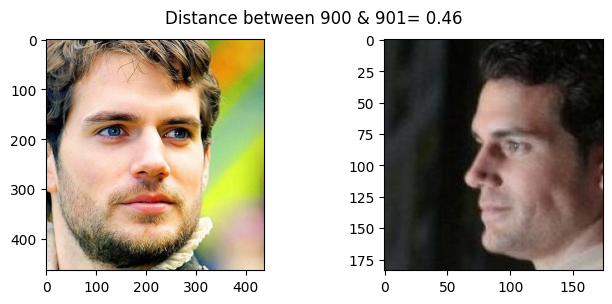

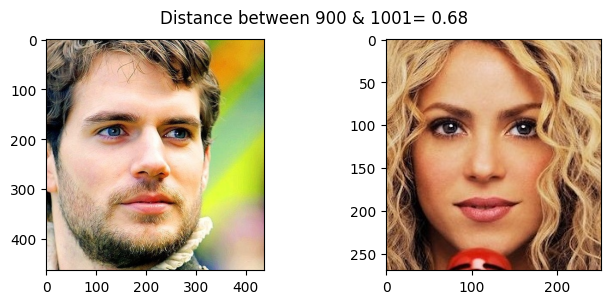

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(900, 901)
show_pair(900, 1001)

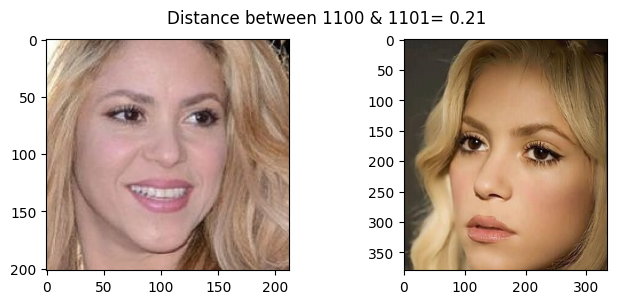

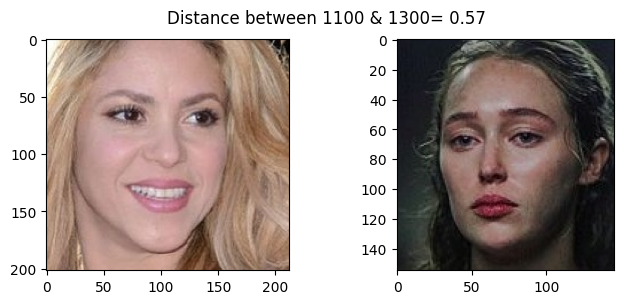

In [ ]:
show_pair(1100, 1101)
show_pair(1100, 1300)

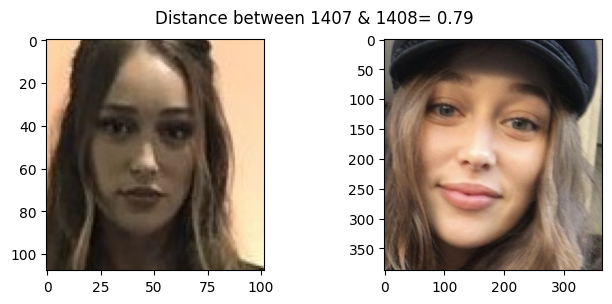

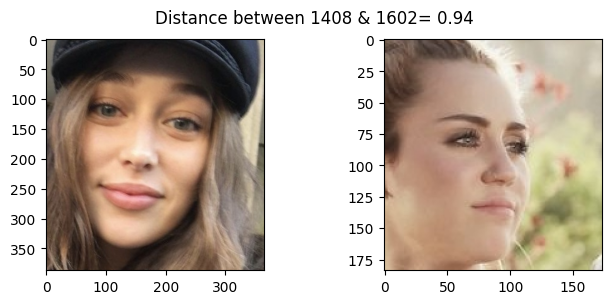

In [ ]:
show_pair(1407, 1408)
show_pair(1408, 1602)

<a id = '4.4'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.4 Create train and test sets </strong></p>
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [ ]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (15585,2622)
y_train shape : (15585,)
X_test shape : (1949,2622)
y_test shape : (1949,)


In [ ]:
y_test[0], y_train[988]

('pins_Chris Evans', 'pins_Shakira Isabel Mebarak')

In [ ]:
len(np.unique(y_test)), len(np.unique(y_train))

(105, 105)

<p style = "font-size:20px; color: #007580 "><strong> Encode the Labels </strong></p>
- Encode the targets
- Use LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [ ]:
print(le.classes_)
y_test_encoded = le.transform(y_test)

['pins_Adriana Lima' 'pins_Alex Lawther' 'pins_Alexandra Daddario'
 'pins_Alvaro Morte' 'pins_Amanda Crew' 'pins_Andy Samberg'
 'pins_Anne Hathaway' 'pins_Anthony Mackie' 'pins_Avril Lavigne'
 'pins_Ben Affleck' 'pins_Bill Gates' 'pins_Bobby Morley'
 'pins_Brenton Thwaites' 'pins_Brian J. Smith' 'pins_Brie Larson'
 'pins_Chris Evans' 'pins_Chris Hemsworth' 'pins_Chris Pratt'
 'pins_Christian Bale' 'pins_Cristiano Ronaldo' 'pins_Danielle Panabaker'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Eliza Taylor'
 'pins_Elizabeth Lail' 'pins_Emilia Clarke' 'pins_Emma Stone'
 'pins_Emma Watson' 'pins_Gwyneth Paltrow' 'pins_Henry Cavil'
 'pins_Hugh Jackman' 'pins_Inbar Lavi' 'pins_Irina Shayk'
 'pins_Jake Mcdorman' 'pins_Jason Momoa' 'pins_Jennifer Lawrence'
 'pins_Jeremy Renner' 'pins_Jessica Barden' 'pins_Jimmy Fallon'
 'pins_Johnny Depp' 'pins_Josh Radnor' 'pins_Katharine Mcphee'
 'pins_Katherine Langford' 'pins_Keanu Reeves' 'pins_Krysten Ritter'
 'pins_Leonardo DiCaprio' 'pins_Lili R

In [ ]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [15 15 15 ... 22 22 22]
y_test_encoded :  [15 15 15 ... 22 22 22]


<p style = "font-size:20px; color: #007580 "><strong> Standardize the feature values </strong></p>
- Scale the features using StandardScaler

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [ ]:
X_test_std = scaler.transform(X_test)

<a id = '4.5'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.5 Reduce dimensions using PCA </strong></p>
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [ ]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (15585,2622)
y_train_encoded shape : (15585,)
X_test_std shape : (1949,2622)
y_test_encoded shape : (1949,)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

<a id = '5.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 5. Model Building and Validation </h2>

<a id = '5.1'></a>
<p style = "font-size:20px; color: #007580 "><strong> 5.1 Build a Machine Learning Classifier </strong></p>

- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [ ]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001)

In [ ]:
y_predict = clf.predict(X_test_pca)

In [ ]:
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)

y_predict :  [15 15 15 ... 22 22 22]
y_test_encoded :  [15 15 15 ... 22 22 22]


In [ ]:
y_predict_encoded = le.inverse_transform(y_predict)

In [ ]:
print('y_predict_encoded : ',y_predict_encoded)

y_predict_encoded :  ['pins_Chris Evans' 'pins_Chris Evans' 'pins_Chris Evans' ...
 'pins_Dwayne Johnson' 'pins_Dwayne Johnson' 'pins_Dwayne Johnson']


In [ ]:
print('y_predict shape : ', y_predict.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

y_predict shape :  (1949,)
y_test_encoded shape :  (1949,)


In [ ]:
y_test_encoded[32:49]

array([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94])

In [ ]:
# Find the classification accuracy
accuracy_score(y_test_encoded, y_predict)

0.9610056439199589

**Accuracy Score: 96.455%**

<a id = '5.2'></a>
<p style = "font-size:20px; color: #007580 "><strong> 5.2 Validate Celebrity Images </strong></p>

- Take  401th  image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

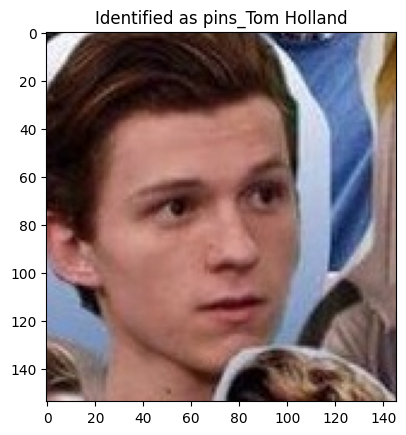

In [ ]:
example_idx = 401

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

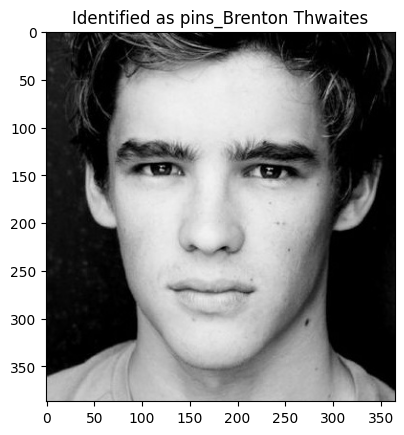

In [ ]:
example_idx = 900

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

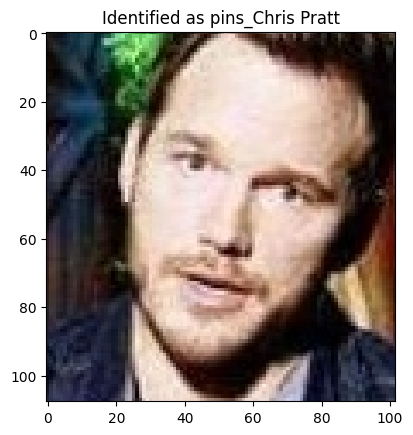

In [ ]:
example_idx = 317

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

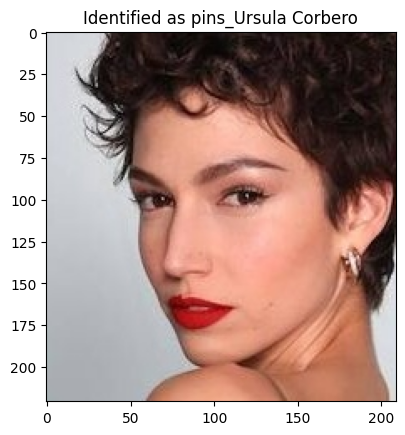

In [ ]:
example_idx = -27

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

<a id = '6.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 6. Conclusion </h2>

1. This dataset contains 17534 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.
2. Generated embeddings for all images using pre-trained VGG Face model.
3. Used "Squared L2 distance" to calculate the distance between given 2 pairs of images.
4. Encoded the target variables, standardize the features and reduced dimensions using PCA.
5. Used SVM classifier to predict the celebrity in a given image and achived a 96.455% accuracy.

- Reference Link for Template used in this notebook - https://www.kaggle.com/bhuvanchennoju/ancient-roots-of-agriculture-a-data-overview

<p style = "font-size:30px; color: #007580 ;background-color:  ; text-align: left; border-radius: 5px 5px; padding: 5px" ><strong> Thanks for reading 🙂</strong></p>